
# Sum_Links files exploration and processing
La idea es levantar atributos para el dataset estandar

* observar estructura de la tabla 
* levantar solo los pares (i,j) donde i & j son users de la telco. Para saber si son users de la teclo es necesario levantar el file del hash_map (user_hash -- > int). Descartando asi el resto de los users.
* extraer features de uso "endemico" para nuestros users de la TelCo
* extraer la info epidemica, de uso total, de uso expuesto,etc por antena para usar luego en los mapas de mexico.

### Obs. este parseo de sum_links da informacion suficiente como para no mirar el file userData

## definiciones utilizadas
* timestamp arranca en 0 segundos para 01/01/2012 00:00am
* La Direction, viene dada relativa al user de la primer columna (incoming si entra y viceversa si es outgoing).
* los calls son un conteo de quantity.
* los usuarios de la Telco pueden venir en Origin o Target indistintamente (i.e. primer o segunda fila de sum_links)
* el time se mide en segundos
* daylight time esta entre [7, 19) horas (exclusivo).
* ignoramos los sms, pues no podemos estar seguros de tener esta info en el dataset Argentino

### el dataset vendria con este header
 {'LineKeyOrigin':hash_object \\\  'LineKeyTarget':np.uint32 \\\  'CallsWeekDayLight':np.uint8 \\\   'CallsWeekNight':np.uint8 \\\  'CallsWeekend':np.uint8 \\\  'TimeWeekDaylight':np.uint8 \\\  'TimeWeekNight':np.uint8 \\\  'TimeWeekend':np.uint8 \\\  'SmsWeekDaylight':np.uint8 \\\  'SmsWeekNight ':np.uint8 \\\  'SmsWeekend':np.uint8} 

In [1]:
import pandas as pd; import numpy as np;
pd.set_option('display.max_rows', 300)
#from matplotlib import pyplot as plt
#%matplotlib inline
import unicodedata
import os
import random
import time

np.random.seed(2016)

In [3]:
#en user_hash_map va a quedar el mapping de hashes por usuario a su int correspondiente.

#users_hash_map= pd.read_csv('/home/juan/mobility-study/output_user_hash_map.txt.gz',
#                       sep = "|",
#                       header=0,
#                       index_col=0)

In [3]:
#seteamos el lugar de trabajo
rootdir="/grandata/voice/sum_links"
os.chdir(rootdir)
year = "2015"; 
month_start= "04";
#todos estos sum_links terminan 2 meses mas tardes
month_end= "0"+str(int(month_start)+2)
input_file= rootdir +"/sum_links_{y}{ms}_{y}{me}.txt.gz".format(y=year,ms=month_start,me=month_end)
output_file = "/home/juan/mobility-study/output_sum_links.txt.gz"

In [5]:
!zcat $input_file | head -n10

LineKeyOrigin|LineKeyTarget|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|SmsWeekDaylight|SmsWeekNight|SmsWeekend
CD5844F7EB2C00C63465E43B44EB9025|3F6FEB3BA73D7E51D906B19F1E0A9099|0|0|0|0|0|0|1|0|0
6AEE0F059A39A7E1CF90B93B5BE8E5AD|3F6FEB3BA73D7E51D906B19F1E0A9099|0|0|0|0|0|0|0|0|3
CD5844F7EB2C00C63465E43B44EB9025|21F587020D72C34131DDD04C0FCD6CFF|0|0|0|0|0|0|0|0|1
CD5844F7EB2C00C63465E43B44EB9025|796D132ECDF757CBCE8FB01DDA3891D6|0|0|0|0|0|0|1|0|0
5E8BADC0F256DEC1ACBB1AB2B77527E9|796D132ECDF757CBCE8FB01DDA3891D6|0|0|3|0|0|203|0|0|0
CD5844F7EB2C00C63465E43B44EB9025|5FA3B22C222AFFF5DFAAE7CFCAEBCA30|0|0|0|0|0|0|0|0|1
6B56A956E1A9E56BE4D90543C8706E76|5FA3B22C222AFFF5DFAAE7CFCAEBCA30|0|0|0|0|0|0|1|0|0
2752F0E0F8226FFF2A3189EB131330AC|46B254E4C1A98CECB4F3D52E66BB836D|1|0|1|196|0|36|0|0|0
2752F0E0F8226FFF2A3189EB131330AC|A954CAD047A827B6DEBA10BD797E7B16|10|4|9|1403|208|1416|0|0|0

gzip: stdout: Broken pipe


## Tests
Veamos cuantos usuarios de un sum_links file dado son users de la telco (por cuestiones de velocidad tomamos solo las filas iniciales)

In [6]:
!du -ha *.txt.gz

7.3G	sum_links_201401_201403.txt.gz
7.3G	sum_links_201404_201406.txt.gz
7.5G	sum_links_201407_201409.txt.gz
8.3G	sum_links_201410_201412.txt.gz
8.4G	sum_links_201501_201503.txt.gz
8.6G	sum_links_201504_201506.txt.gz
8.6G	sum_links_201507_201509.txt.gz


In [7]:
!zcat "/home/juan/mobility-study/output2.txt.gz" | head -n7

USER,EXPOSED,ANTENNA_ID_0,COUNT_0,ANTENNA_ID_1,COUNT_1,ANTENNA_ID_2,COUNT_2,ANTENNA_ID_3,COUNT_3,ANTENNA_ID_4,COUNT_4,ANTENNA_ID_5,COUNT_5,ANTENNA_ID_6,COUNT_6,ANTENNA_ID_7,COUNT_7,ANTENNA_ID_8,COUNT_8,ANTENNA_ID_9,COUNT_9,EPIDEMIC,MOBILITY_DIAMETER
FFFF78CB080636632B2D1DE7A7BFAB03,False,3415,21,2969,5,1320,3,2471,3,1115,2,-1,65535,-1,65535,-1,65535,-1,65535,-1,65535,False,1063.14053495
FFFF51FDDD55A2E24D074DE30C4798E9,True,1207,15,1171,14,1820,9,583,8,2026,5,1066,4,1831,4,1625,2,401,1,825,1,False,520.065958971
FFFE1EDDA25369CBC467536FA6A787FD,True,1847,22,1753,14,1422,11,1028,10,765,9,3072,9,862,8,2463,7,1416,6,871,5,True,989.597851013
FFFD0A912A959CDFCFFAB2F93BFBA435,True,1407,18,1702,8,1613,6,1704,5,1394,3,1398,3,818,2,958,2,726,1,848,1,False,490.58538164
FFFCB235D6D917DDF350F5B11CCB0EE8,True,17,74,174,33,1123,4,1178,4,173,3,890,2,503,1,1039,1,1228,1,1327,1,True,1613.22560564
FFFC9EC4F662C44D3006BA69C9F0DE85,True,876,19,1737,6,1744,5,326,1,378,1,503,1,1118,1,2216,1,2477,1,2962,1,Tru

In [10]:
user_epidemic = pd.read_csv(
                "/home/juan/mobility-study/output2.txt.gz",
                engine = 'c',
                sep = ',',
                header = 0,
                index_col=0,
                dtype = {'EPIDEMIC':np.bool,'EXPOSED':np.bool,
                         'ANTENNA_ID_0':np.int16},
                usecols = ['USER','EPIDEMIC','EXPOSED','ANTENNA_ID_0']
                )
## ojo con setear los dtypes para las antennas en np.usigned int pues ahi me transforma todos los -1s en el max del dtype
user_epidemic.index.name = 'LineKeyOrigin'

#para luego filtrar por los users de la telco que nos interesan
simple_format_hashes = np.unique(user_epidemic.index.values)

In [8]:
## leemos de a chunks todo el file y lo agregamos a la tabla con los valores que nos importan

#ver el tiempo que tarda
start_time = time.time()

table = pd.DataFrame()
for month_start in ["04","07"]:
    year = "2015"
    print("reading month {m} of {tot_n} months, current time is {t} \n".\
              format(m= month_start,tot_n = 2,t=(time.time()-start_time)))
    #todos estos sum_links terminan 2 meses mas tardes
    month_end= "0"+str(int(month_start)+2)
    input_file= rootdir +"/sum_links_{y}{ms}_{y}{me}.txt.gz".format(y=year,ms=month_start,me=month_end)
    raw_table = pd.read_csv(input_file,
                         sep = "|", 
                         header =0,
                         index_col = None,
                         usecols = ['LineKeyOrigin', 'LineKeyTarget', 'CallsWeekDaylight',
                                    'CallsWeekNight','CallsWeekend','TimeWeekDaylight','TimeWeekNight','TimeWeekend'],
                         chunksize = 6*10**7,    
                        engine = 'c',
                         lineterminator='\n',
                         skipinitialspace=True, 
                        error_bad_lines= False,
                        warn_bad_lines= True,
                        dtype = {'CallsWeekDaylight':np.uint16,'CallsWeekNight':np.uint16,'CallsWeekend':np.uint16,
                                          'TimeWeekDaylight':np.uint16,'TimeWeekNight':np.uint16,'TimeWeekend':np.uint16}
                           )
    numb=0;
    for chunk in raw_table:
        numb+=1
        print("reading chunk #{n} of {tot_n}, current time is {t}".\
              format(n=numb,tot_n = 8,t=(time.time()-start_time)))

        table = table.append(chunk[chunk['LineKeyOrigin'].isin(simple_format_hashes) & chunk['LineKeyTarget'].isin(simple_format_hashes)])

#como leo varios meses puede haber dos ocurencias distintas para un par (origin,target)
table = table.groupby(['LineKeyOrigin','LineKeyTarget']).sum()
#vuelvo el indice a como estaba
table.reset_index(inplace = True, level=[0,1])        

print("\n total running time of script is %d " % (time.time() -  start_time))

reading month 04 of 2 months, current time is 0.0014660358429 

reading chunk #1 of 8, current time is 158.149121046
reading chunk #2 of 8, current time is 502.817826986
reading chunk #3 of 8, current time is 952.136212111
reading chunk #4 of 8, current time is 1415.96756697
reading chunk #5 of 8, current time is 1863.77269316
reading chunk #6 of 8, current time is 2095.96160197
reading month 07 of 2 months, current time is 2113.26918507 

reading chunk #1 of 8, current time is 2522.31523895
reading chunk #2 of 8, current time is 2962.05234694
reading chunk #3 of 8, current time is 3413.30693412
reading chunk #4 of 8, current time is 3850.32980108
reading chunk #5 of 8, current time is 4286.95573115
reading chunk #6 of 8, current time is 4538.20009708

 total running time of script is 4633 


### Errors readinglines
algunas lineas no las pudo procesar el C-Parser porque decia que *Error tokenizing data. C error: Expected11 fields in line 189999971,  saw 21* asi que recorro con el error_bad_lines = $False$ y warn_bad_lines = $True$ para luego chequear a mano con sed i.e.

!zcat \$input_file | sed -n '189999969,\$p' | head

In [9]:
!zcat $input_file | sed -n '189999969,$p' | head

gzip: compressed data not read from a terminal. Use -f to force decompression.
For help, type: gzip -h


### Results mirando si (i,j) $\in$ telco_users x telco_users
* intentamos leer un "sample" de la tabla poinendo usando el parametro skiprows = random_bool_array, pero tardaba muchiimo en seleccionar 10^7 filas
* corrida 1: 3.5M de 10M de pares (i,j) eran telco users
* corrida 2: 0.5M de 10M de pares (i,j) eran telco users
* corrida 3: 1.2M de 20M de pares (i,j) eran telco users
* corrida 4: 1.7M de 20M de pares (i,j) eran telco users
* corrida 5: 0.9M de 20M de pares (i,j) eran telco users

In [10]:
#chequeamos que este todo bien levantado
table['LineKeyTarget'].isin(simple_format_hashes).values.all()and (table['LineKeyOrigin'].isin(simple_format_hashes)).values.all()

True

## filas que no 'aportan' datos. i.e. todas nulas

In [ ]:
relevant_cols = [col for col in table.columns.values \
                 if (not('EPIDEMIC' in col) and not('Line' in col) and not('ANTENNA' in col) )]
#imprimimos las filas que tienen todas las columnas ==0 (en los atributos relevantes), i.e. no hay info a extraer
#y eliminamos estas filas
null_rows= table[(table[relevant_cols].T ==0).all()].index


In [ ]:
table.drop(null_rows,inplace=True)

#### Saving preoutput file for faster loading
A veces pasa que el kernel se muere o por alguna razon perdemos ese espacio en memoria de *table* donde tenemos muchisimos datos ya procesados que tardan mucho tiempo en volver a procesar

In [8]:
preoutput_file = output_file.replace("output","preoutput")

In [8]:
#guardo por las dudas para levantar mas rapido a futuro
table.to_csv(preoutput_file, 
             index = False, 
             header = True,
             float_format='%.0f',
             compression = 'gzip',
             sep="|")

NameError: name 'table' is not defined

#### Loading preoutput file

In [10]:
!zcat /home/juan/mobility-study/preoutput_sum_links.txt.gz | head

LineKeyOrigin|LineKeyTarget|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend
00000837B868F926F67BD440A0845C1D|5350FBED91E7DA465D7D436ADD1C48F3|0.0|0.0|2.0|0.0|0.0|45.0
00000837B868F926F67BD440A0845C1D|C88DD6FDDF73AF80517291EEA7339B32|1.0|2.0|1.0|47.0|74.0|64.0
000017368A8964F8C71A9F3A1EAF6160|11509D6701C5280D0D0B2271246424B0|1.0|0.0|0.0|318.0|0.0|0.0
000017368A8964F8C71A9F3A1EAF6160|651D2B4E897DB722F28EDB856F4909FE|2.0|0.0|0.0|165.0|0.0|0.0
000017368A8964F8C71A9F3A1EAF6160|FB36428E265F633EC2227140BDDCCB4D|1.0|0.0|0.0|147.0|0.0|0.0
00001ADC8C5705AB4FD8197B5024C1AA|203B6D6813D904D1E9F39EBB40F00C5D|1.0|0.0|0.0|48.0|0.0|0.0
00001ADC8C5705AB4FD8197B5024C1AA|719FD9FE4C22689FF010BD7C15C28A17|0.0|3.0|0.0|0.0|121.0|0.0
00001ADC8C5705AB4FD8197B5024C1AA|CD4F8B895DBF929F0E3ACA3086469CF6|6.0|2.0|3.0|696.0|86.0|176.0
00001ADC8C5705AB4FD8197B5024C1AA|D828A3318C8C24914FE361221029D3EC|0.0|0.0|1.0|0.0|0.0|42.0

gzip: stdout: Broken pipe


In [33]:
table = pd.read_csv( "/home/juan/mobility-study/preoutput_sum_links.txt.gz",
                              header =0,
                              index_col=None,
                              engine="c",
                              sep="|",
                               #dtype = {'CallsWeekDaylight':np.uint16,'CallsWeekNight':np.uint16,'CallsWeekend':np.uint16,
                                #          'TimeWeekDaylight':np.uint16,'TimeWeekNight':np.uint16,'TimeWeekend':np.uint16}                          
                                )

cols = [col for col in table.columns if not('Line' in col) ]
#levanto todo en float, lo paso a int (excepto los hashes)
table[cols] = table[cols].astype(int)

In [67]:
test[[col for col in test if not('Calls' in col) and not('Time' in col) and not('Line' in col)]]

,EPIDEMIC,ANTENNA_ID_0,EPIDEMIC_Target,ANTENNA_ID_0_Target
0,False,650,False,650
1,False,650,False,650
2,True,815,False,414
3,True,815,False,1896
4,True,815,True,707
5,False,340,True,1859
6,False,340,False,432
7,False,340,False,365
8,False,340,True,395
9,True,989,False,1147


In [95]:
#agrego la info de epidemicidad de los targets.
table = table.join(user_epidemic[['EPIDEMIC','ANTENNA_ID_0']], on='LineKeyOrigin',how='left',rsuffix='_Origin')
table = table.join(user_epidemic[['EPIDEMIC','ANTENNA_ID_0']], on='LineKeyTarget',how='left',rsuffix='_Target')
table.rename(columns={'EPIDEMIC':"EPIDEMIC_Origin", 'ANTENNA_ID_0':"ANTENNA_ID_0_Origin"},inplace=True)
#del user_epidemic

In [131]:
table.head(20)

,LineKeyOrigin,LineKeyTarget,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC_Origin,ANTENNA_ID_0_Origin,EPIDEMIC_Target,ANTENNA_ID_0_Target
0,00000837B868F926F67BD440A0845C1D,5350FBED91E7DA465D7D436ADD1C48F3,0,0,2,0,0,45,False,650,False,650
1,00000837B868F926F67BD440A0845C1D,C88DD6FDDF73AF80517291EEA7339B32,1,2,1,47,74,64,False,650,False,650
2,000017368A8964F8C71A9F3A1EAF6160,11509D6701C5280D0D0B2271246424B0,1,0,0,318,0,0,True,815,False,414
3,000017368A8964F8C71A9F3A1EAF6160,651D2B4E897DB722F28EDB856F4909FE,2,0,0,165,0,0,True,815,False,1896
4,000017368A8964F8C71A9F3A1EAF6160,FB36428E265F633EC2227140BDDCCB4D,1,0,0,147,0,0,True,815,True,707
5,00001ADC8C5705AB4FD8197B5024C1AA,203B6D6813D904D1E9F39EBB40F00C5D,1,0,0,48,0,0,False,340,True,1859
6,00001ADC8C5705AB4FD8197B5024C1AA,719FD9FE4C22689FF010BD7C15C28A17,0,3,0,0,121,0,False,340,False,432
7,00001ADC8C5705AB4FD8197B5024C1AA,CD4F8B895DBF929F0E3ACA3086469CF6,6,2,3,696,86,176,False,340,False,365
8,00001ADC8C5705AB4FD8197B5024C1AA,D828A3318C8C24914FE361221029D3EC,0,0,1,0,0,42,False,340,True,395
9,00001B448AE41076EB2C58ABEAF0E0C8,277AF4248D7C631F7F022C98BD64773F,0,1,1,0,31,29,True,989,False,1147


# Agrego en un .sum() la info de sum_links por antenna y por KeyOrigin
OBS importante al 17/03. La informacion p/c/ user de la telco puede venir en la columna Origin o Target indistintamente, el orden solo marca la 'direccion' de la informacion luego habria que repetir el analisis swappeando las columnas (para ahora tener la otra direccion) 

In [32]:
def unique(array):
    order = np.lexsort(array.T)
    array = array[order]
    diff = np.diff(array, axis=0)
    ui = np.ones(len(array), 'bool')
    ui[1:] = (diff != 0).any(axis=1) 
    return array[ui]

In [51]:
prueba = np.array([[1,2],[1,3],[1,3],[1,5],[2,1],[2,1]]) 
unique(prueba)

array([[2, 1],
       [1, 2],
       [1, 3],
       [1, 5]])

In [33]:
b = unique(antenna_table[['ANTENNA_ID_0','ANTENNA_ID_0_Target']].values)

In [34]:
len(b), antenna_table.shape

(2233264, (2233264, 8))

### Result OK

### Sanity checking im not losing users
hicimos una comparacion de la tabla antes y despues de la ultima linea de codigo y da que
len(np.unique(table.LineKeyOrigin.values)) == 640647
len(np.unique(output.index.levels[0].values)) == 640647

In [35]:
i = random.randint(0,9200)
antenna_table.iloc[i:i+4,].groupby('ANTENNA_ID_0').apply(get_epidemic_agregator)

KeyError: 'EPIDEMIC_Target'

In [36]:
antenna_table.iloc[i:i+4,]

,ANTENNA_ID_0,ANTENNA_ID_0_Target,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend
3432,4,965,42,14,22,2939,2131,1448
3433,4,974,3,0,0,1351,0,0
3434,4,977,0,0,1,0,0,104
3435,4,994,0,2,0,0,191,0


### Result OK

# General epidemic_aggregator algorithm

In [9]:
table.head()

,LineKeyOrigin,LineKeyTarget,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC_Origin,ANTENNA_ID_0,EPIDEMIC_Target,ANTENNA_ID_0_Target
0,00000837B868F926F67BD440A0845C1D,5350FBED91E7DA465D7D436ADD1C48F3,0,0,2,0,0,45,False,650,False,650
1,00000837B868F926F67BD440A0845C1D,C88DD6FDDF73AF80517291EEA7339B32,1,2,1,47,74,64,False,650,False,650
2,000017368A8964F8C71A9F3A1EAF6160,11509D6701C5280D0D0B2271246424B0,1,0,0,318,0,0,True,815,False,414
3,000017368A8964F8C71A9F3A1EAF6160,651D2B4E897DB722F28EDB856F4909FE,2,0,0,165,0,0,True,815,False,1896
4,000017368A8964F8C71A9F3A1EAF6160,FB36428E265F633EC2227140BDDCCB4D,1,0,0,147,0,0,True,815,True,707


In [10]:
table.shape

(5015519, 12)

In [11]:
%%time
rel_cols = ['LineKeyOrigin'] + [col for col in table.columns if ('Calls' in col) or ('Time' in col) ] 
all_info = table[rel_cols].groupby('LineKeyOrigin').sum()
epi_info = table[table['EPIDEMIC_Target']==1][rel_cols].groupby('LineKeyOrigin').sum()
epi_info.columns = [col+"_EPI" for col in epi_info.columns]

result = pd.concat([all_info, epi_info], axis=1)
#ojo que este concat introduce nulls donde no hay index compartido entre los dataframes pues el join es 'outer'

#reagrego la columna linekeyorigin
result.index.name=rel_cols[0]
#result.reset_index(level =0, inplace=True)
# sin embargo no esperamos que haya nulls en las columnas relevantes
print(result[rel_cols[1:]].isnull().sum().sum())
#entonces rellenamos los valores faltantes con 0..
result = result.fillna(0)

0
CPU times: user 8.12 s, sys: 1.43 s, total: 9.55 s
Wall time: 9.6 s


## Direccion de llamado
SumLinks tiene en cuenta la direccion del llamado pero en este script vamos a agregar esta informacion, luego debemos rotar la informacion de la dataframe de sum_links i.e. swapear origin con target y toda esa info relevante para el mismo algoritmo.

In [208]:
table.head(2)

,LineKeyOrigin,LineKeyTarget,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC_Origin,ANTENNA_ID_0_Origin,EPIDEMIC_Target,ANTENNA_ID_0_Target
0,00000837B868F926F67BD440A0845C1D,5350FBED91E7DA465D7D436ADD1C48F3,0,0,2,0,0,45,False,650,False,650
1,00000837B868F926F67BD440A0845C1D,C88DD6FDDF73AF80517291EEA7339B32,1,2,1,47,74,64,False,650,False,650


In [13]:
#swapeo los nombres de las columnas, dropeo epidemic y lo vuelvo a agregar para los nuevos users swappeados
table=table.rename(columns = {'LineKeyOrigin':'LineKeyTarget',
                        'LineKeyTarget':'LineKeyOrigin',
                             'EPIDEMIC_Origin':'EPIDEMIC_Target',
                              'EPIDEMIC_Target':'EPIDEMIC_Origin'})

In [207]:
table.head(2)

,LineKeyOrigin,LineKeyTarget,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC_Origin,ANTENNA_ID_0_Origin,EPIDEMIC_Target,ANTENNA_ID_0_Target
0,00000837B868F926F67BD440A0845C1D,5350FBED91E7DA465D7D436ADD1C48F3,0,0,2,0,0,45,False,650,False,650
1,00000837B868F926F67BD440A0845C1D,C88DD6FDDF73AF80517291EEA7339B32,1,2,1,47,74,64,False,650,False,650


In [15]:
%%time
rel_cols = ['LineKeyOrigin'] + [col for col in table.columns if ('Calls' in col) or ('Time' in col) ] 
all_info = table[rel_cols].groupby('LineKeyOrigin').sum()
epi_info = table[table['EPIDEMIC_Target']==1][rel_cols].groupby('LineKeyOrigin').sum()
epi_info.columns = [col+"_EPI" for col in epi_info.columns]

output = pd.concat([all_info, epi_info], axis=1)
#ojo que este concat introduce nulls donde no hay index compartido entre los dataframes pues el join es 'outer'

#reagrego la columna linekeyorigin
output.index.name=rel_cols[0]
#output.reset_index(level =0, inplace=True)
# sin embargo no esperamos que haya nulls en las columnas relevantes
print(output[rel_cols[1:]].isnull().sum().sum())
#entonces rellenamos los valores faltantes con 0..
output = output.fillna(0)

0
CPU times: user 21.5 s, sys: 1.44 s, total: 23 s
Wall time: 23.1 s


In [16]:
#junto las dos tablas sumando la info
output = result.add(output,fill_value=0)
output = output.astype(int)

In [25]:
output.sample(10)

,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TimeWeekDaylight_EPI,TimeWeekNight_EPI,TimeWeekend_EPI
LineKeyOrigin,,,,,,,,,,,,
BACB1D82BD1B8AF9B32EA4F8D7E92F35,2,1,2,129,120,277,2,0,0,129,0,0
C2A82A4E9F562E2BAF844FC86F8D5AC9,28,2,29,2755,88,2322,4,0,0,720,0,0
FB930FDC87FB0D74575591AD25E4B3C1,8,1,17,268,41,1006,2,0,0,80,0,0
ABA71E9F66EB07891952F85E3B728A77,7,3,0,465,264,0,0,0,0,0,0,0
3A58668D91D1E4B326ABF635D07E420F,1,10,2,26,526,345,0,0,0,0,0,0
FBCBFD504C185BFE2671086B341B0C81,0,2,2,0,178,326,0,2,2,0,178,326
D200CA663DA423FA63662EB9B5C686C3,9,3,3,619,474,493,0,0,0,0,0,0
70B6A357FF1C5C77CA6F46A168B9145E,21,1,3,2279,56,165,0,0,0,0,0,0
2735D6E154534BFA4E2FF94C8639EE27,71,7,6,13473,703,1845,7,3,3,953,158,1529


## Data validation/ Sanity check
Chequeamos que lo que esperabamos que suceda realmente haya sucedido.. i.e.

Que no haya mas calls/times epidemicos vs los valores desagregados

Que no hayamos perdido users en el camino.



In [21]:
#checking that all "_EPI" should be smaller or equal then their non_EPI column
for col in rel_cols:
    if col == 'LineKeyOrigin':
        continue
    epi_col = col+"_EPI"
    print("col {0} is <= than col {1}: {2}".format(epi_col,col,
                                (output[epi_col] <= output[col]).all()  ))

table_hashes = set(table.LineKeyOrigin.values) | set(table.LineKeyTarget.values)
print(np.in1d(output.index.values, np.asarray(table_hashes)).all())
print(np.in1d(table.LineKeyOrigin.values, output.index.values ).all())
print( len(table_hashes),len(output) )

col CallsWeekDaylight_EPI is <= than col CallsWeekDaylight: True
col CallsWeekNight_EPI is <= than col CallsWeekNight: True
col CallsWeekend_EPI is <= than col CallsWeekend: True
col TimeWeekDaylight_EPI is <= than col TimeWeekDaylight: True
col TimeWeekNight_EPI is <= than col TimeWeekNight: True
col TimeWeekend_EPI is <= than col TimeWeekend: True
[False False False ..., False False False]
True
(2449242, 2449242)


## Sample Check
randomly select a user with low phone usage and check that sum aggregations were correctly done. 

In [144]:
output[output['CallsWeekDaylight']<8].sample(5)

,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TimeWeekDaylight_EPI,TimeWeekNight_EPI,TimeWeekend_EPI
LineKeyOrigin,,,,,,,,,,,,
422EDADD9BABB844A891F0C9D54EE353,4,0,0,196,0,0,0,0,0,0,0,0
559D1CC97E77A7A064E071F094C7EFA9,0,0,2,0,0,170,0,0,2,0,0,170
5C32FAB96D93FEAB99E1CE8AF48499BE,3,3,5,158,324,229,3,1,5,158,49,229
B9DE64DA0E44BCB4623E4F374FA1F550,7,0,1,1955,0,42,7,0,1,1955,0,42
9653896BF495D9BEF34B2065E923453C,2,0,0,59,0,0,0,0,0,0,0,0


In [153]:
user = "9653896BF495D9BEF34B2065E923453C"
table[(table['LineKeyOrigin']==user ) | (table['LineKeyTarget']==user )][rel_cols+
                                                                         ['EPIDEMIC_Origin','EPIDEMIC_Target']+['LineKeyTarget']]

,LineKeyOrigin,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC_Origin,EPIDEMIC_Target,LineKeyTarget
3693749,BC692C84F844309A6A4C4949A9E7B283,2,0,0,59,0,0,False,False,9653896BF495D9BEF34B2065E923453C


In [154]:
output.loc[user,:]

CallsWeekDaylight         2
CallsWeekNight            0
CallsWeekend              0
TimeWeekDaylight         59
TimeWeekNight             0
TimeWeekend               0
CallsWeekDaylight_EPI     0
CallsWeekNight_EPI        0
CallsWeekend_EPI          0
TimeWeekDaylight_EPI      0
TimeWeekNight_EPI         0
TimeWeekend_EPI           0
Name: 9653896BF495D9BEF34B2065E923453C, dtype: int64


## Falta agregar la info de Total Exp_users and Epi_users interaction

In [182]:
%%time
# me genero la tabla con los pares (i,j) y concateno con la tabla pero swappeando en (j,i) para lograr hacer los counts apropiados

user_pair = table.loc[:,['LineKeyOrigin','LineKeyTarget']]
user_pair2 = user_pair.loc[:,['LineKeyTarget','LineKeyOrigin']]
user_pair2.columns = ['LineKeyOrigin','LineKeyTarget']
user_pair = pd.concat([user_pair,user_pair2])

#agrego la informacion epidemica y de exposicion
user_pair = user_pair.join(user_epidemic[['EPIDEMIC','EXPOSED']],on = 'LineKeyTarget', how = 'left',rsuffix='_Target')
del user_pair2

# UNIQUE # of users count

#primero agrupo por el par (i,j) para no tener dos veces el par y agrupo 
#(el agregador es "bobo" no voy a estar usando la info de esta agrupacion)
total_users = user_pair.groupby(['LineKeyOrigin','LineKeyTarget']).count()
total_users = total_users.reset_index()
total_users.rename(columns={'EPIDEMIC':'TOTAL_USERS'},inplace=True)
# ahora conteo los usuarios unicos
total_users = total_users.groupby('LineKeyOrigin')['TOTAL_USERS'].count()
total_users = total_users.to_frame()
total_users = total_users.reset_index()

# EPIDEMIC & EXPOSED count
#primero agrupo por el par (i,j) para no tener dos veces el par y agrupo 
#(el agregador es "bobo" no voy a estar usando la info de esta agrupacion)

epidemic_count = user_pair[user_pair['EPIDEMIC']==1]\
                .groupby(['LineKeyOrigin','LineKeyTarget'])['EPIDEMIC'].count()
epidemic_count = epidemic_count.reset_index()
epidemic_count.rename(columns={'EPIDEMIC':'EPI_USERS'},inplace=True)

exposed_count = user_pair[user_pair['EXPOSED']==1]\
                .groupby(['LineKeyOrigin','LineKeyTarget'])['EXPOSED'].count()
exposed_count = exposed_count.reset_index()
exposed_count.rename(columns={'EXPOSED':'EXP_USERS'},inplace=True)

#reseteo el indice
#epidemic_count = epidemic_count.reset_index()
#exposed_count = exposed_count.reset_index()

#ahora si agrupo y cuento c/ par unico (Origin,Target)
epidemic_count = epidemic_count.groupby(['LineKeyOrigin'])['EPI_USERS'].count()
exposed_count = exposed_count.groupby(['LineKeyOrigin'])['EXP_USERS'].count()

epidemic_count = epidemic_count.to_frame()
exposed_count = exposed_count.to_frame()
del user_pair

#agrego la informacion epidemica y de exposicion en total_users y relleno los NaNs con 0s i.e. ausencia de conteos
total_users = total_users.join(epidemic_count['EPI_USERS'],on = 'LineKeyOrigin', how = 'left').fillna(0)
total_users = total_users.join(exposed_count['EXP_USERS'],on = 'LineKeyOrigin', how = 'left').fillna(0)

del exposed_count, epidemic_count

total_users.set_index('LineKeyOrigin',inplace=True)

print("total algo time for {n} users is ".format(n=(len(total_users))))

total algo time for 2449242 users is 
CPU times: user 1min 39s, sys: 5.77 s, total: 1min 45s
Wall time: 1min 46s


## Sanity check
Chequeamos cantidad de usuarios en la tabla resultante y algunos casos particulares al azar

In [212]:
#check that all "_EPI" should be smaller or equal then their non_EPI column
tot_cols =['TOTAL_USERS','EPI_USERS','EXP_USERS']
print("col {0} is >= than col {1}: {2}".format(tot_cols[0],tot_cols[1],
                                (total_users[tot_cols[0]] >= total_users[tot_cols[1]]).all()  ))
print("col {0} is >= than col {1}: {2}".format(tot_cols[0],tot_cols[2],
                                (total_users[tot_cols[0]] >= total_users[tot_cols[2]]).all()  ))
print("col {0} is >= than col {1}: {2}".format(tot_cols[2],tot_cols[1],
                                (total_users[tot_cols[2]] >= total_users[tot_cols[1]]).all()  ))

col TOTAL_USERS is >= than col EPI_USERS: True
col TOTAL_USERS is >= than col EXP_USERS: True
col EXP_USERS is >= than col EPI_USERS: True


In [222]:
#random sample checking
total_users.sample(5)

,TOTAL_USERS,EPI_USERS,EXP_USERS
LineKeyOrigin,,,
B06733AF9D40DC1651772C41275175D9,2,1.0,2.0
97A26C014BA4DDE450C33FFFCD2F3DE0,6,2.0,6.0
53B67E6364AA6CB770AAD9B3077F7E77,1,1.0,1.0
52710482361E29361CC758D1CE4FB078,3,0.0,3.0
35915601558FAC4D52E702FD0C494BBE,5,1.0,5.0


In [223]:
user = "97A26C014BA4DDE450C33FFFCD2F3DE0"

In [224]:
total_users.loc[user,:]

TOTAL_USERS    6.0
EPI_USERS      2.0
EXP_USERS      6.0
Name: 97A26C014BA4DDE450C33FFFCD2F3DE0, dtype: float64

In [225]:
relevant_cols = [col for col in table.columns if ('Line' in col) or ('EPIDEMIC' in col) or ('ANTENNA' in col) ]
table[table['LineKeyOrigin']==user][relevant_cols]

,LineKeyOrigin,LineKeyTarget,EPIDEMIC_Origin,ANTENNA_ID_0_Origin,EPIDEMIC_Target,ANTENNA_ID_0_Target
2973542,97A26C014BA4DDE450C33FFFCD2F3DE0,1186E338814D501B80FC6A5C89A8A1A0,True,1260,False,1487
2973543,97A26C014BA4DDE450C33FFFCD2F3DE0,AD6D0FD2BE1D3D7572AA70977BEF75B9,True,1260,False,116
2973544,97A26C014BA4DDE450C33FFFCD2F3DE0,B421A1802F04609D6DA52C041A03E8EC,True,1260,False,183


In [226]:
table[table['LineKeyTarget']==user][relevant_cols]

,LineKeyOrigin,LineKeyTarget,EPIDEMIC_Origin,ANTENNA_ID_0_Origin,EPIDEMIC_Target,ANTENNA_ID_0_Target
344815,1186E338814D501B80FC6A5C89A8A1A0,97A26C014BA4DDE450C33FFFCD2F3DE0,False,1487,True,1260
2129552,6CB98184EC44EE71FF593AE3905FC2C5,97A26C014BA4DDE450C33FFFCD2F3DE0,False,2559,True,1260
2844999,910DF21B708576CC88A1F5CAF5BF820C,97A26C014BA4DDE450C33FFFCD2F3DE0,True,1231,True,1260
3399385,AD6D0FD2BE1D3D7572AA70977BEF75B9,97A26C014BA4DDE450C33FFFCD2F3DE0,False,116,True,1260
3695690,BC8270290E538D42251BD888A456AC2D,97A26C014BA4DDE450C33FFFCD2F3DE0,True,335,True,1260


### Fast sanity_check 
number of users & expected results

In [203]:
total_users.shape,len(np.unique(total_users.index.values)) 

((2449242, 3), 2449242)

In [204]:
len(set(np.unique(table.LineKeyOrigin.values))  | set(np.unique(table.LineKeyTarget.values)) )

2449242

In [205]:
len(np.unique(output.index.values)), output.shape

(2449242, (2449242, 12))

### Results

In [228]:
total_users[total_users['TOTAL_USERS'] < total_users.TOTAL_USERS.quantile(0.99)]['TOTAL_USERS'].hist()

ImportError: pygobject version too old -- it must have require_version

In [229]:
total_users['EXP_USERS'].hist()

ImportError: pygobject version too old -- it must have require_version

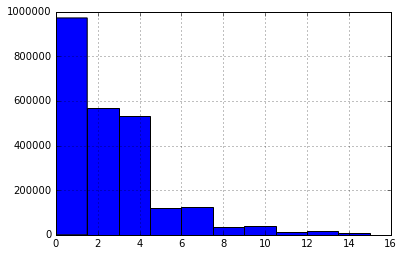

In [469]:
total_users[total_users['EXP_USERS'] < total_users.EXP_USERS.quantile(0.99)]['EXP_USERS'].hist()

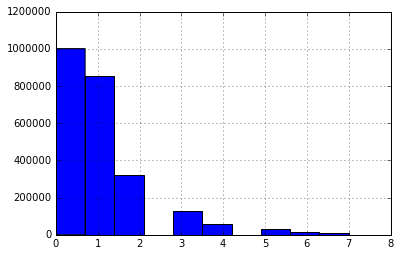

In [470]:
total_users[total_users['EPI_USERS'] < total_users.EPI_USERS.quantile(0.99)]['EPI_USERS'].hist()

In [864]:
total_users.head()

,TOTAL_USERS,EPI_USERS,EXP_USERS
LineKeyOrigin,,,
000004F96010462FA7A71C7784E27476,1,0,1
000007EEE7895E17937CFF86379C8E17,1,1,1
00000837B868F926F67BD440A0845C1D,3,0,2
00000C5D3BFBEBD919F6F68386C3DD5E,1,0,1
0000129F4191FFD0963774D2307C7510,2,0,2


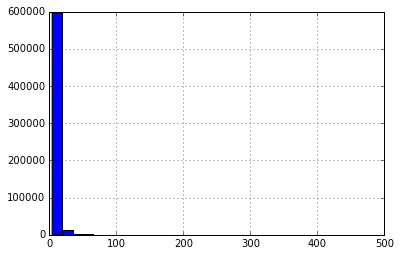

In [880]:
total_users[total_users['TOTAL_USERS']>total_users['TOTAL_USERS'].mean()]['TOTAL_USERS'].hist(bins=30)

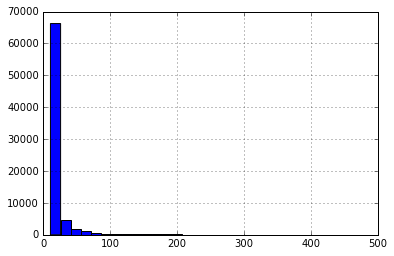

In [881]:
total_users[total_users['TOTAL_USERS']> 10]['TOTAL_USERS'].hist(bins=30)

In [878]:
total_users['TOTAL_USERS'].mean()

3.0996928845740848

## add Info to output table

In [230]:
output = pd.merge(output,total_users,how='inner',right_index=True,left_index=True).astype(int)

In [60]:
output.shape

(2449242, 22)

In [232]:
output_file

'/home/juan/mobility-study/output_sum_links.txt.gz'

In [234]:
#guardo por las dudas para levantar mas rapido a futuro
output.to_csv(output_file, 
             index = True, 
             header = True,
             float_format='%.0f',
              compression = 'gzip',
             sep="|")

In [235]:
!zcat $output_file  |head

LineKeyOrigin|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI|TOTAL_USERS|EPI_USERS|EXP_USERS
000004F96010462FA7A71C7784E27476|0|0|1|0|0|34|0|0|0|0|0|0|1|0|1
000007EEE7895E17937CFF86379C8E17|2|0|0|144|0|0|2|0|0|144|0|0|1|1|1
00000837B868F926F67BD440A0845C1D|1|6|3|47|160|109|0|0|0|0|0|0|3|0|2
00000C5D3BFBEBD919F6F68386C3DD5E|4|0|0|281|0|0|0|0|0|0|0|0|1|0|1
0000129F4191FFD0963774D2307C7510|2|0|0|66|0|0|0|0|0|0|0|0|2|0|2
000017368A8964F8C71A9F3A1EAF6160|7|0|1|960|0|58|1|0|0|147|0|0|4|1|4
00001ADC8C5705AB4FD8197B5024C1AA|8|10|5|773|542|359|1|0|1|48|0|42|4|2|4
00001B448AE41076EB2C58ABEAF0E0C8|15|13|11|1319|736|488|4|0|4|275|0|116|2|1|2
00001C544BEBBB9109CE3552B4CDC490|0|1|0|0|36|0|0|0|0|0|0|0|1|0|1

gzip: stdout: Broken pipe


In [236]:
!du -ha $output_file 

74M	/home/juan/mobility-study/output_sum_links.txt.gz


## Reload output table


In [884]:
test.columns

Index([u'CallsWeekDaylight', u'CallsWeekDaylight_EPI', u'CallsWeekNight',
       u'CallsWeekNight_EPI', u'CallsWeekend', u'CallsWeekend_EPI',
       u'TimeWeekDaylight', u'TimeWeekDaylight_EPI', u'TimeWeekNight',
       u'TimeWeekNight_EPI', u'TimeWeekend', u'TimeWeekend_EPI',
       u'TOTAL_USERS', u'EPI_USERS', u'EXP_USERS'],
      dtype='object')

In [5]:
#levanto
table = pd.read_csv(output_file, 
             index_col = 0, 
             header = 0,
             engine = 'c',
             sep="|"
            #dtype = {'CallsWeekDaylight':np.uint16,'CallsWeekNight':np.uint16,'CallsWeekend':np.uint16,
             #'TimeWeekDaylight':np.uint16,'TimeWeekNight':np.uint16,'TimeWeekend':np.uint16,
              #      'CallsWeekDaylight_EPI':np.uint16,'CallsWeekNight_EPI':np.uint16,'CallsWeekend_EPI':np.uint16,
             #'TimeWeekDaylight_EPI':np.uint16,'TimeWeekNight_EPI':np.uint16,'TimeWeekend_EPI':np.uint16,
             #       u'TOTAL_USERS':np.uint16, u'EPI_USERS':np.uint16, u'EXP_USERS':np.uint16}                                              
                    )

# Sanity checking im not losing users in the algorithm

In [33]:
only_non_epidemic_users = list(set(table[table['EPIDEMIC_Origin']==0].LineKeyOrigin.values) - set(table[table['EPIDEMIC_Origin']==1].LineKeyOrigin.values))

In [36]:
print(table.shape)
print(table[~table['LineKeyOrigin'].isin(only_non_epidemic_users)].shape)
print(table[table['LineKeyOrigin'].isin(only_non_epidemic_users)].shape)

(5015519, 11)
(1862025, 11)
(3153494, 11)


In [38]:
(table['LineKeyOrigin'].isin(only_non_epidemic_users).isnull()).any()

False

In [39]:
non_epi_hashes =np.unique(table[~table['LineKeyOrigin'].isin(only_non_epidemic_users)].LineKeyOrigin.values)
epi_hashes = np.unique(table[table['LineKeyOrigin'].isin(only_non_epidemic_users)].LineKeyOrigin.values)
len(epi_hashes) + len(non_epi_hashes)

1927239

In [40]:
table_hashes = np.unique(table['LineKeyOrigin'].values)
print len(table_hashes)
print len(epi_hashes) + len(non_epi_hashes)

1927239
1927239


In [43]:
len(simple_format_hashes)

3667451

## Results
Levantamos en sum_links 1927239 usuarios de la Telco que tienen al menos 1 interaccion con otro users de la misma TelCo
Sin embargo en la tabla de simple_format ya procesada, tengo 3667451 users de la Telco.
Lo que creo que esta sucediendo es que hay 1.5M de users que NO hablan con otro usuario de la telco.... Raro.

Habria que testear en simple_format de levantar de vuelta los useres pertinentes asi nos

## More sanity checking
Obs.. podria estar pasando que estamos droppeando todas esas filas que eran interacciones unicamente por SMS (interaccion que no estamos mirando actualmente pues descartamos esas columnas directamente). Pero mirando el dato crudo con grep ( zcat sum_links_201504_201506.txt.gz | grep -m 10 "00000C5D3BFBEBD919F6F68386C3DD5E") encontramos users de la Telco que interactuan con este y en formato de llamadas, luego estamos perdiendo users en otro lado..

HAY QUE recorrer el algoritmo que levanta users para ver donde se estarian cayendo estas interacciones y rever si es el parser o si lo 'dropeamos' el valor en algun lado. La nueva tabla la vamos a guardar en la variable table justamente

In [239]:
output_hashes = output.index.values

In [241]:
print(len(np.unique(output_hashes)))
print(len(output_hashes))

1927239
1927239


In [42]:
print(len(table_hashes))

1927239


In [286]:
np.in1d(table_hashes,output_hashes,assume_unique=True).all()

False

In [52]:
#me fijo aquellos que estan en la simple_f pero que no estan en la tabla
out_of_table_hashes = simple_format_hashes[~np.in1d(simple_format_hashes,table_hashes,assume_unique=True)]

In [56]:
out_of_table_hashes.shape

(1740212,)

#### buscamos con grep a estos users dentro de los sum_link files a ver que estaria pasando
* Las ultimas 3 filas son de sms con lo cual NO se incluyen en nuestro procesamiento de sum_links
* Tmb podria pasar que haya una interaccion entre dos usuarios, unos de los cuales no es de la Telco, luego se excluye esta linea.


In [98]:
i=random.randint(0,len(out_of_table_hashes)-1)
user = (out_of_table_hashes[i])
slinks_file1 = "/grandata/voice/sum_links/sum_links_201504_201506.txt.gz"
slinks_file2 = "/grandata/voice/sum_links/sum_links_201507_201509.txt.gz"
user

'F8527ACF3BD6B2E6664FEB7993820E8D'

In [99]:
start_time = time.time()
!zcat $slinks_file1 | grep -m 10 "$user" 
elapsed_time = time.time()-start_time
print("total algo time for this cell is {t}".format( t= elapsed_time))

485AAB7A278EA2BC2B434386103B3CDD|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|1|0|0|58|0|0|0
299403B5EDEF0B0D6F42D7A09A8EDC39|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|0|0|0|0|1|1|0
F7A0CA7A5B32D2172B95A0ECE69C1622|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|0|0|0|0|0|1|0
80DBF1C2031A8A6400CC4A5367DB2F5B|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|1|0|0|1|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|80DBF1C2031A8A6400CC4A5367DB2F5B|2|0|0|48|0|0|0|0|0
E7B7DB6EBECA9C15063D3EA58BFE20C5|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|0|0|0|0|0|3|0
F8527ACF3BD6B2E6664FEB7993820E8D|39E50DC04A11501518F91D47F5E3B504|1|0|3|44|0|141|0|0|0
39E50DC04A11501518F91D47F5E3B504|F8527ACF3BD6B2E6664FEB7993820E8D|1|0|0|20|0|0|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|3F69156BBD56452D7DDF5D3FF1302F20|0|1|1|0|27|30|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|1CBE2653BC1D2985AC8BF2955EE935DA|0|0|0|0|0|0|0|0|1

gzip: stdout: Broken pipe
total algo time for this cell is 114.504776001


In [100]:
start_time = time.time()
!zcat $slinks_file2 | grep -m 10 "$user" 
elapsed_time = time.time()-start_time
print("total algo time for this cell is {t}".format( t= elapsed_time))

F8527ACF3BD6B2E6664FEB7993820E8D|19438BC43AA0A0CB76B1318377CA3EA6|0|0|0|0|0|0|11|0|0
D76AD351C6DC8FB1372F303247548DD2|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|1|0|0|109|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|D76AD351C6DC8FB1372F303247548DD2|0|0|0|0|0|0|0|0|1
7BC568EDB9B2D918941E7EADBBD3A970|F8527ACF3BD6B2E6664FEB7993820E8D|2|1|2|416|43|91|0|0|0
A80EB03346181E8D557EEA6E6C82E98F|F8527ACF3BD6B2E6664FEB7993820E8D|121|27|61|25380|6273|12159|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|8072C7CE1B843532FFC51DBDF6123C83|2|0|1|258|0|269|0|0|0
total algo time for this cell is 597.377434969


In [111]:
#test if other link is telco user
other_user = '8072C7CE1B843532FFC51DBDF6123C83'
other_user in simple_format_hashes

False

### Results
O eran solo interacciones por SMS o eran interacciones donde algun usuario del par ()i,j era no_Telco

### Por las dudas levantamos todos los hashes que encontremos en sum_links, donde al menos un user es Telco 
Lo unico que cambia es el & por un | final en el chequeo isin(simple_format_hashes)

In [37]:
a = (set(simple_format_hashes[100:200])&b) | a&b | (set(simple_format_hashes[300:400]) & set(simple_format_hashes[290:300]))

In [52]:
## leemos de a chunks todo el file y lo agregamos a la tabla con los valores que nos importan

#ver el tiempo que tarda
start_time = time.time()
table_hashes_set = set()
simple_format_set = set(simple_format_hashes)
#table = pd.DataFrame()
for month_start in ["04","07"]:
    year = "2015"
    print("\nreading month {m} of {tot_n} months, current time is {t} \n".\
              format(m= month_start,tot_n = 2,t=(time.time()-start_time)))
    #todos estos sum_links terminan 2 meses mas tardes
    month_end= "0"+str(int(month_start)+2)
    input_file= rootdir +"/sum_links_{y}{ms}_{y}{me}.txt.gz".format(y=year,ms=month_start,me=month_end)
    raw_table = pd.read_csv(input_file,
                         sep = "|", 
                         header =0,
                         index_col = None,
                         usecols = ['LineKeyOrigin', 'LineKeyTarget'],
                         chunksize = 6*10**7,    
                        engine = 'c',
                         lineterminator='\n',
                         skipinitialspace=True, 
                        error_bad_lines= False,
                        warn_bad_lines= True,
                        #dtype = {'CallsWeekDaylight':np.uint16,'CallsWeekNight':np.uint16,'CallsWeekend':np.uint16,
                        #                  'TimeWeekDaylight':np.uint16,'TimeWeekNight':np.uint16,'TimeWeekend':np.uint16}
                           )

    numb=0;
    for chunk in raw_table:
        numb+=1
        print("reading chunk #{n} of {tot_n}, current time is {t}".\
              format(n=numb,tot_n = 8,t=(time.time()-start_time))) 
        table_hashes_set |= set(chunk['LineKeyOrigin'].values)&(simple_format_set) | set(chunk['LineKeyTarget'].values)&(simple_format_set)
        #table = table.append()

#como leo varios meses puede haber dos ocurencias distintas para un par (origin,target)

print("\n total running time of script is %d " % (time.time() -  start_time))



reading month 04 of 2 months, current time is 1.74087095261 

reading chunk #1 of 8, current time is 406.557054996
reading chunk #2 of 8, current time is 701.653960943
reading chunk #3 of 8, current time is 924.011265039
reading chunk #4 of 8, current time is 1138.56422305
reading chunk #5 of 8, current time is 1294.23157096

reading month 07 of 2 months, current time is 1326.59937096 

reading chunk #1 of 8, current time is 1487.06844401
reading chunk #2 of 8, current time is 1710.70073485
reading chunk #3 of 8, current time is 1929.73881197
reading chunk #4 of 8, current time is 2150.85129404
reading chunk #5 of 8, current time is 2308.18230391


NameError: name 'table' is not defined

In [246]:
#esto dice que todos los hashes de la table inicial estan en el conjunto final de output
np.in1d(table_hashes,output_hashes,assume_unique=True).all()

True

In [55]:
len(table_hashes_set & simple_format_set),len(simple_format_set)

(3664648, 3667451)

In [252]:
out_of_table_hashes = simple_format_hashes[~np.in1d(simple_format_hashes,output_hashes,assume_unique=True)]

In [253]:
out_of_table_hashes[:10]

array(['000004F96010462FA7A71C7784E27476',
       '000007EEE7895E17937CFF86379C8E17',
       '00000C5D3BFBEBD919F6F68386C3DD5E',
       '000011F2BE4C5E7D456026CD791185B3',
       '0000129F4191FFD0963774D2307C7510',
       '00002365F59A06246C1CCD3A43CAC09F',
       '000027B6096C6F19310E90FEAD73762B',
       '00002B778CE130C58F44B3D00FF2CE64',
       '00003105C23E8692A295A5B225D16636',
       '00003E0B659DBBB237C1EA4E3ACF3A6C'], dtype=object)

### Result
practicamente no hay perdida de usuarios. Por lo que la caida de users en el dataset original viene por el lado de que
hay algunos telco_users que en esos 6 meses no hablan con NINGUN otro telco_user y solamente con gente fuera del dataset

Idem cuando miramos al azar un user particular y 'grepeamos' los archivos de sum_links. Al analizar los otros usuario s con los que tiene contacto resulta que son o solo contactos por SMS o solo contactos con non_telco_user

Encontramos 3664648 users en sum_links y originalmente parseamos 3667451 en simple_format

# Antenna vuln users
Extraer la info de cuantos usarios viven en c/ antenna y cuantos son vulnerables etc.

Idem con los calls

Notar que aca por definicion EPI_USERS en esa antenna se define por si el usuario tuvo algun contacto con OTHER user epidemico (dondel OTHER puede ser de otra o la misma antenna). IDEM con EXP_USERs.

### Descripcion de la tabla
* Total_USERS es la cantidad de usuarios con base en la antenna A
* EPI_USERS, la cantidad de users de la antenna A que tuvieron al menos una interaccion con otro user epidemico de la misma antenna o cualquier otra.
* EXP_USERS, igual que antes pero EXP.

* EXP_Target_USERS: a cuantos users expuestos llamo la antenna A, sin incluir users de A.
* EXP_Origin_USERS: cuantos users de A son users expuestos (que hayan usado alguna antenna epidemica alguna vez).


In [6]:
output.head()

,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TimeWeekDaylight_EPI,TimeWeekNight_EPI,TimeWeekend_EPI,TOTAL_USERS,EPI_USERS,EXP_USERS
LineKeyOrigin,,,,,,,,,,,,,,,
000004F96010462FA7A71C7784E27476,0,0,1,0,0,34,0,0,0,0,0,0,1,0,1
000007EEE7895E17937CFF86379C8E17,2,0,0,144,0,0,2,0,0,144,0,0,1,1,1
00000837B868F926F67BD440A0845C1D,1,6,3,47,160,109,0,0,0,0,0,0,3,0,2
00000C5D3BFBEBD919F6F68386C3DD5E,4,0,0,281,0,0,0,0,0,0,0,0,1,0,1
0000129F4191FFD0963774D2307C7510,2,0,0,66,0,0,0,0,0,0,0,0,2,0,2


In [44]:
output2 = output.copy()

In [11]:
output = output.join(user_epidemic['ANTENNA_ID_0'],how='left',rsuffix='_Origin')
calls_cols = [col for col in output.columns if "Calls" in col]
time_cols =  [col for col in output.columns if "Time" in col]

epi_calls_cols = [col for col in output.columns if ("Calls" in col and "EPI" in col)]
epi_time_cols =  [col for col in output.columns if ("Time" in col and "EPI" in col)]

output['TOTAL_Calls'] = output[calls_cols].sum(axis =1).values
output['TOTAL_Time'] = output[time_cols].sum(axis =1).values

output['TOTAL_EPI_Calls'] = output[epi_calls_cols].sum(axis = 1).values
output['TOTAL_EPI_Time'] = output[epi_time_cols].sum(axis = 1).values

In [42]:
calls_cols = [col for col in output.columns if "Calls" in col]
time_cols =  [col for col in output.columns if "Time" in col]

antenna2vuln = output.groupby('ANTENNA_ID_0')[calls_cols + time_cols].sum()

In [45]:
output.head()

,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TimeWeekDaylight_EPI,...,TOTAL_USERS,EPI_USERS,EXP_USERS,ANTENNA_ID_0,TOTAL_Calls,TOTAL_Time,TOTAL_EPI_Calls,TOTAL_EPI_Time,1EPI_USER,1EXP_USER
LineKeyOrigin,,,,,,,,,,,,,,,,,,,,,
000004F96010462FA7A71C7784E27476,0,0,1,0,0,34,0,0,0,0,...,1,0,1,2937,1,34,0,0,0,1
000007EEE7895E17937CFF86379C8E17,2,0,0,144,0,0,2,0,0,144,...,1,1,1,625,4,288,2,144,1,1
00000837B868F926F67BD440A0845C1D,1,6,3,47,160,109,0,0,0,0,...,3,0,2,650,10,316,0,0,0,1
00000C5D3BFBEBD919F6F68386C3DD5E,4,0,0,281,0,0,0,0,0,0,...,1,0,1,1325,4,281,0,0,0,1
0000129F4191FFD0963774D2307C7510,2,0,0,66,0,0,0,0,0,0,...,2,0,2,2226,2,66,0,0,0,1


In [14]:
# 1EPI_USER vendria a ser como if USER Interacted with at least 1 epidemic user in that month 
output['1EPI_USER'] = (output['EPI_USERS']>=1).astype(int).values
output['1EXP_USER'] = (output['EXP_USERS']>=1).astype(int).values

In [46]:
# como el groupby es sorted by default, no tengo el problema del desorden aca.
antenna2vuln['EXP_USERS'] = output.groupby('ANTENNA_ID_0')['1EXP_USER'].sum()
antenna2vuln['EPI_USERS'] = output.groupby('ANTENNA_ID_0')['1EPI_USER'].sum()
antenna2vuln['TOTAL_USERS'] = output.groupby('ANTENNA_ID_0')['TOTAL_USERS'].count()

In [47]:
antenna2vuln.head()

,CallsWeekDaylight,CallsWeekNight,CallsWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TOTAL_Calls,TOTAL_EPI_Calls,TimeWeekDaylight,TimeWeekNight,TimeWeekend,TimeWeekDaylight_EPI,TimeWeekNight_EPI,TimeWeekend_EPI,TOTAL_Time,TOTAL_EPI_Time,EXP_USERS,EPI_USERS,TOTAL_USERS
ANTENNA_ID_0,,,,,,,,,,,,,,,,,,,
1,12787,6178,5944,7568,3339,3223,39039,14130,1352028,822011,750888,748550,423776,418547,4515800,1590873,854,586,862
2,13043,7436,7097,6584,3219,3274,40653,13077,1605549,1025268,832785,752277,413743,343501,4973123,1509521,1092,662,1106
3,18401,8966,8421,8315,4285,4025,52413,16625,2204147,1321580,960480,928534,556219,418888,6389848,1903641,941,641,948
4,8878,5733,5691,5926,3890,3677,33795,13493,1166484,992407,729013,741374,651785,447756,4728819,1840915,623,460,629
5,5678,3487,3711,2658,1791,1903,19228,6352,612525,427256,417892,298476,220012,194098,2170259,712586,503,365,506


In [20]:
antenna2vuln.columns

Index([u'CallsWeekDaylight', u'CallsWeekNight', u'CallsWeekend',
       u'CallsWeekDaylight_EPI', u'CallsWeekNight_EPI', u'CallsWeekend_EPI',
       u'TOTAL_Calls', u'TOTAL_EPI_Calls', u'TimeWeekDaylight',
       u'TimeWeekNight', u'TimeWeekend', u'TimeWeekDaylight_EPI',
       u'TimeWeekNight_EPI', u'TimeWeekend_EPI', u'TOTAL_Time',
       u'TOTAL_EPI_Time', u'EXP_USERS', u'EPI_USERS', u'TOTAL_USERS'],
      dtype='object')

In [49]:
old_cols = """TOTAL_USERS,EPI_USERS,EXP_USERS,
CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,
CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TOTAL_Calls,TOTAL_EPI_Calls,TimeWeekDaylight_EPI,
TimeWeekNight_EPI,TimeWeekend_EPI,TOTAL_Time,TOTAL_EPI_Time"""
new_cols =old_cols.replace("\n","").replace(" ","").split(",")

In [50]:
new_cols

['TOTAL_USERS',
 'EPI_USERS',
 'EXP_USERS',
 'CallsWeekDaylight',
 'CallsWeekNight',
 'CallsWeekend',
 'TimeWeekDaylight',
 'TimeWeekNight',
 'TimeWeekend',
 'CallsWeekDaylight_EPI',
 'CallsWeekNight_EPI',
 'CallsWeekend_EPI',
 'TOTAL_Calls',
 'TOTAL_EPI_Calls',
 'TimeWeekDaylight_EPI',
 'TimeWeekNight_EPI',
 'TimeWeekend_EPI',
 'TOTAL_Time',
 'TOTAL_EPI_Time']

In [51]:
# chequeo consistencia del reorden
antenna2vuln[new_cols].shape, antenna2vuln.shape

((4178, 19), (4178, 19))

In [53]:
antenna2vuln = antenna2vuln[new_cols]

In [58]:
ant_file = "/home/juan/mobility-study/mexico_ant2vuln_aggregation.txt"
antenna2vuln.to_csv(ant_file, 
             index = True, 
             header = True,
             float_format='%.0f',
             sep="|")

In [59]:
!head $ant_file

ANTENNA_ID_0|TOTAL_USERS|EPI_USERS|EXP_USERS|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TOTAL_Calls|TOTAL_EPI_Calls|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI|TOTAL_Time|TOTAL_EPI_Time
1|862|586|854|12787|6178|5944|1352028|822011|750888|7568|3339|3223|39039|14130|748550|423776|418547|4515800|1590873
2|1106|662|1092|13043|7436|7097|1605549|1025268|832785|6584|3219|3274|40653|13077|752277|413743|343501|4973123|1509521
3|948|641|941|18401|8966|8421|2204147|1321580|960480|8315|4285|4025|52413|16625|928534|556219|418888|6389848|1903641
4|629|460|623|8878|5733|5691|1166484|992407|729013|5926|3890|3677|33795|13493|741374|651785|447756|4728819|1840915
5|506|365|503|5678|3487|3711|612525|427256|417892|2658|1791|1903|19228|6352|298476|220012|194098|2170259|712586
6|590|413|583|8544|4278|4375|989851|614566|474512|4820|2304|2458|26779|9582|550166|314929|264692|3208716|1129787
7|1763|